In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram

DATA_DIR = Path('../data')
PROC_DIR = Path(DATA_DIR / 'original/processed')
OUT_DIR = Path('./out/pca_joint_std')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 7

# Helper Functions

In [2]:
def plot_km_results(cluster_count, labels, series):
    plot_count = math.ceil(math.sqrt(cluster_count))
    fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series[i],c="gray",alpha=0.4)
                cluster.append(series[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0
    plt.tight_layout()
    plt.show()    
    
def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None):
    """Plot cluster of the original data (not scaled)"""  
    
    if nclusters < 2:
        print('Cluster count must be greater than 1')
        return
    
    fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 5*nclusters))
    for idx, flow in enumerate(flows_dict.values()):
        for col_pos, col in enumerate(columns):
            axs[(labels[idx], col_pos)].plot(flow[col], linewidth=0.5)
            axs[(labels[idx], col_pos)].set(ylabel=col, title=f'Cluster {labels[idx]}')
            
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

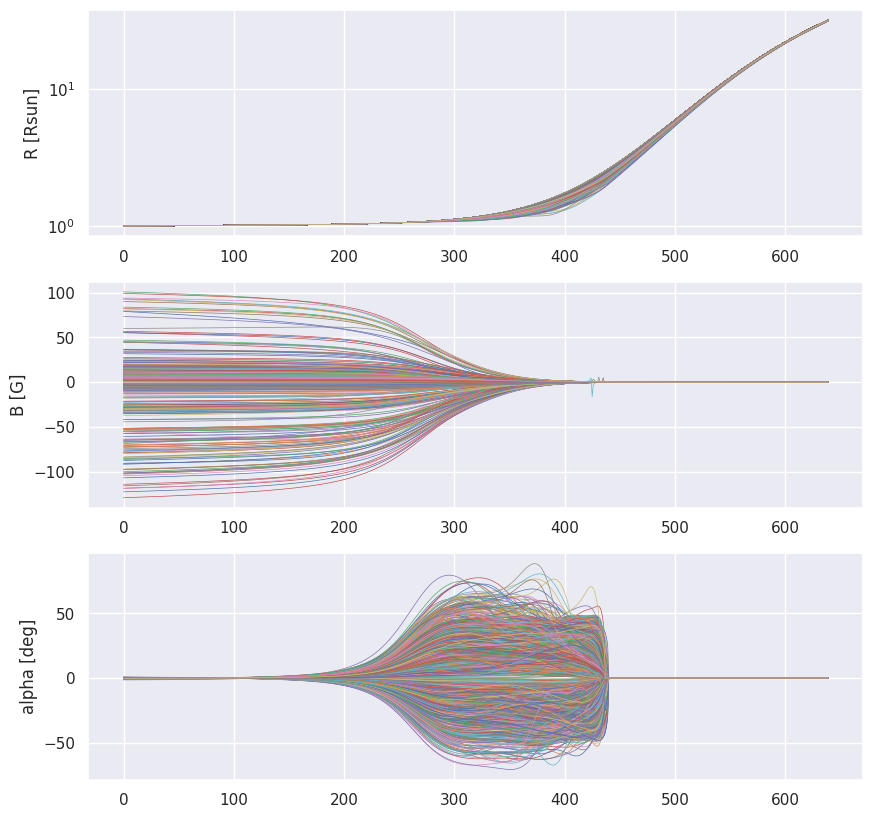

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
# axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [5]:
# scaled_flows = pd.DataFrame()

# # concat flows
# for series in flows_dict.values():
#     scaled_flows = pd.concat([scaled_flows, series], axis=0)

# scaler = MinMaxScaler((-1,1))
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)


# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [6]:
scaled_flows = pd.DataFrame()

# concat flows
for series in flows_dict.values():
    scaled_flows = pd.concat([scaled_flows, series], axis=0)

scaler = RobustScaler()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0 -0.046817  2.856559    -0.370078
1 -0.046785  2.855820    -0.369062
2 -0.046752  2.855080    -0.368020
3 -0.046720  2.854338    -0.366954
4 -0.046688  2.853594    -0.365861


# All Columns

In [7]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(1179, 1920)

In [8]:
scaled_all[0][:20]

array([-0.04681672,  2.85655891, -0.37007819, -0.04678459,  2.85582044,
       -0.36906186, -0.04675244,  2.85508021, -0.36802045, -0.04672026,
        2.85433821, -0.36695366, -0.04668806,  2.85359441, -0.36586118,
       -0.04665584,  2.85284879, -0.3647427 , -0.04662359,  2.85210134])

## PCA

In [9]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_all)
transf_pca_640 = pca_640.transform(scaled_all)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

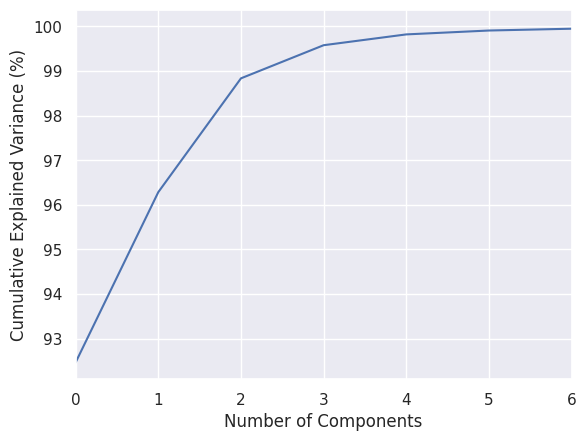

In [10]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

> **Dimensionality**: Most of the data (about 98%) is explained by only 2 components

In [11]:
pca = PCA(n_components=2)
transformed_all = pca.fit_transform(scaled_all)
transformed_all.shape

(1179, 2)

<AxesSubplot: >

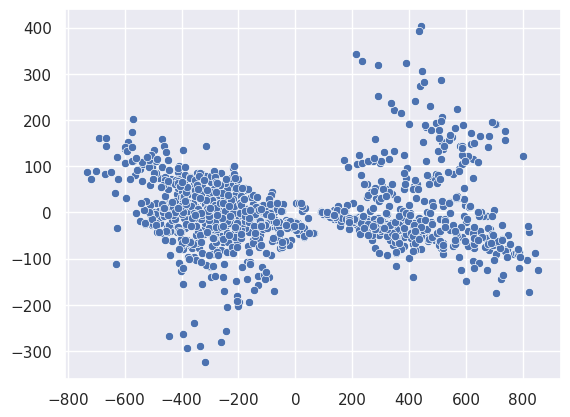

In [12]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

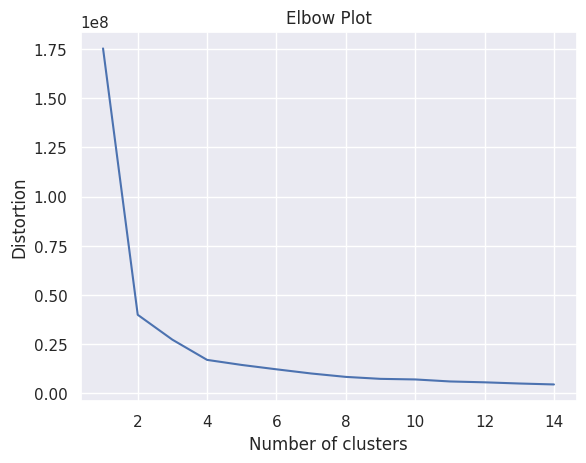

In [13]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [14]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')
pca_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(pca_kmeans_labels))

<AxesSubplot: >

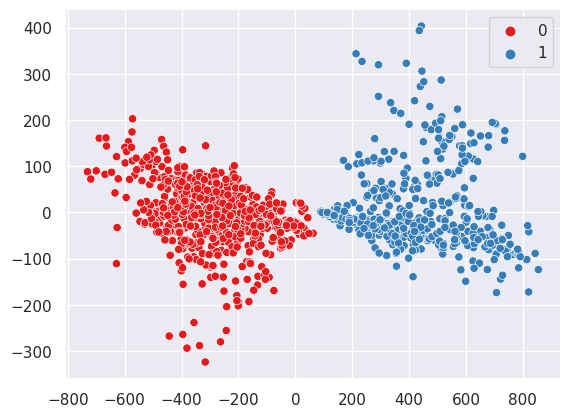

In [15]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=pca_kmeans_labels, palette='Set1')

### Original Data

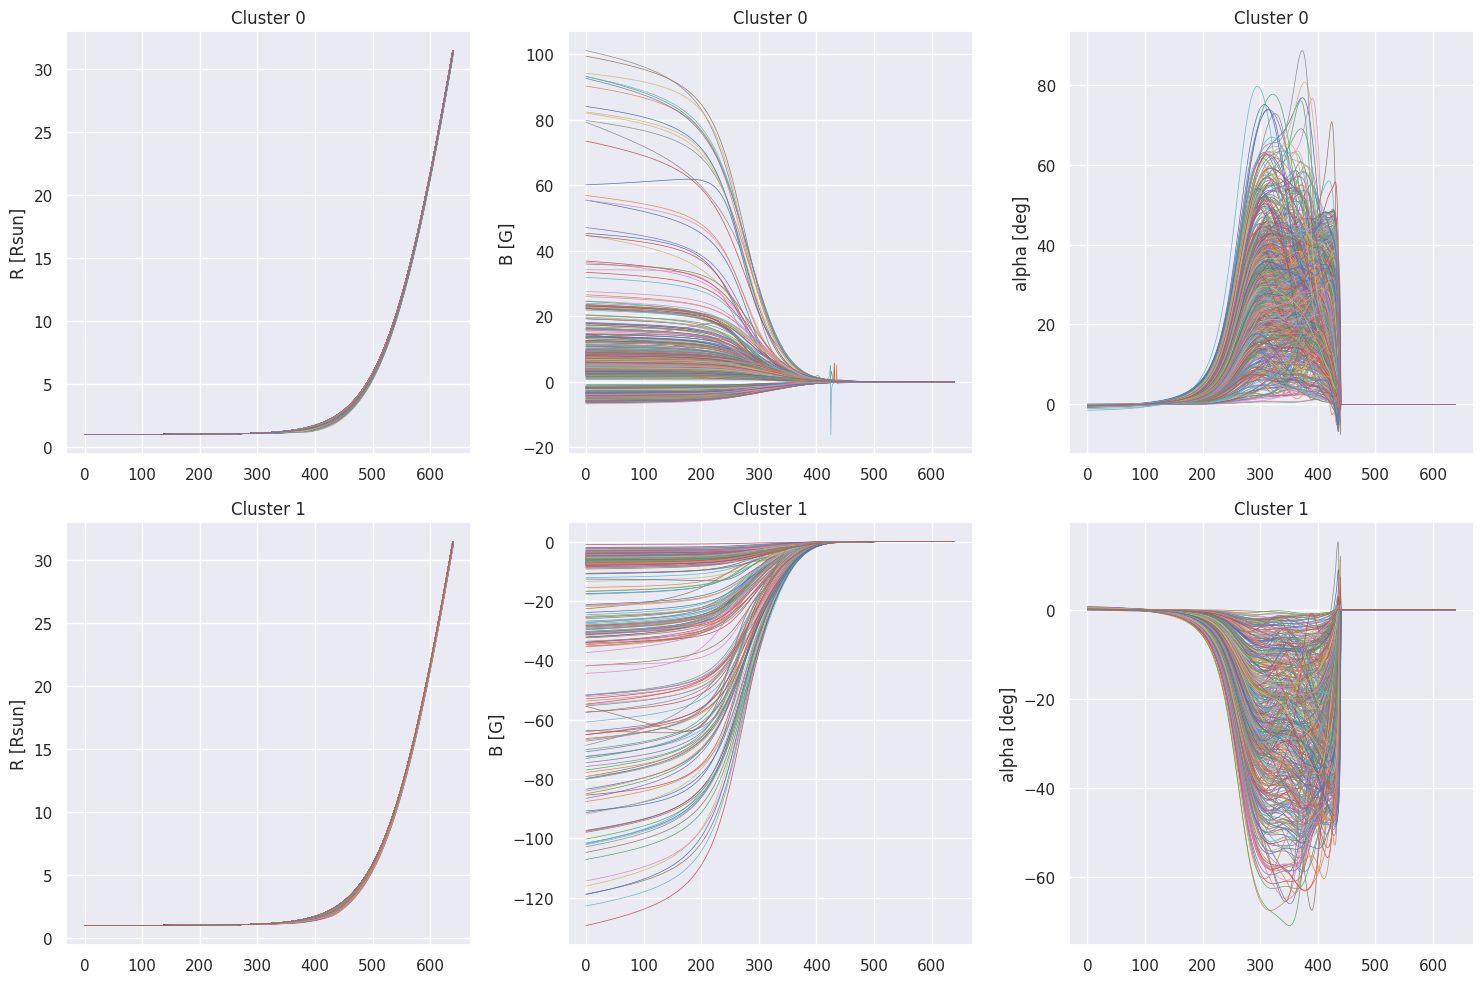

In [16]:
plot_unscaled_clusters(pca_kmeans_labels, nclusters, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

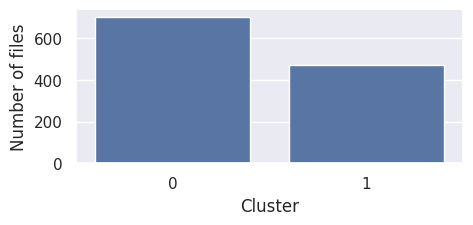

In [17]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [18]:
%%capture
subdir = OUT_DIR / 'kmeans'
if not subdir.exists():
    subdir.mkdir(parents=True)
    
for k in range(2, MAX_CLUSTERS):
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans_labels = kmeans.fit_predict(transformed_all)
    
    sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
    plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
    plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png')

## Hierarchical Clustering

In [19]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=3, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

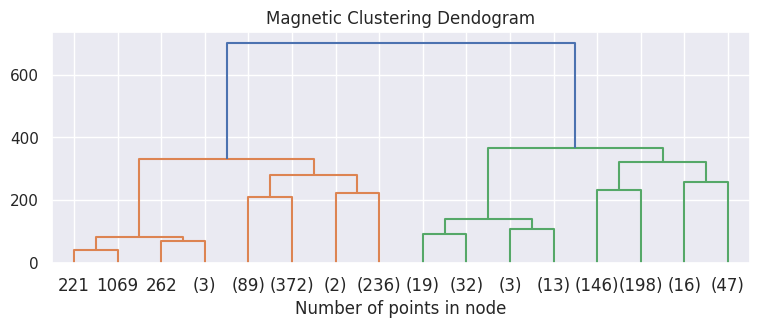

In [20]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

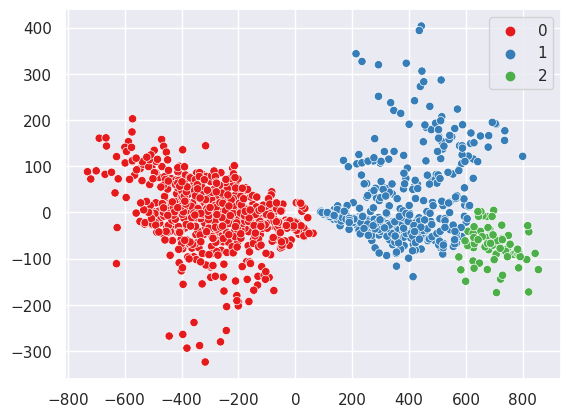

In [21]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

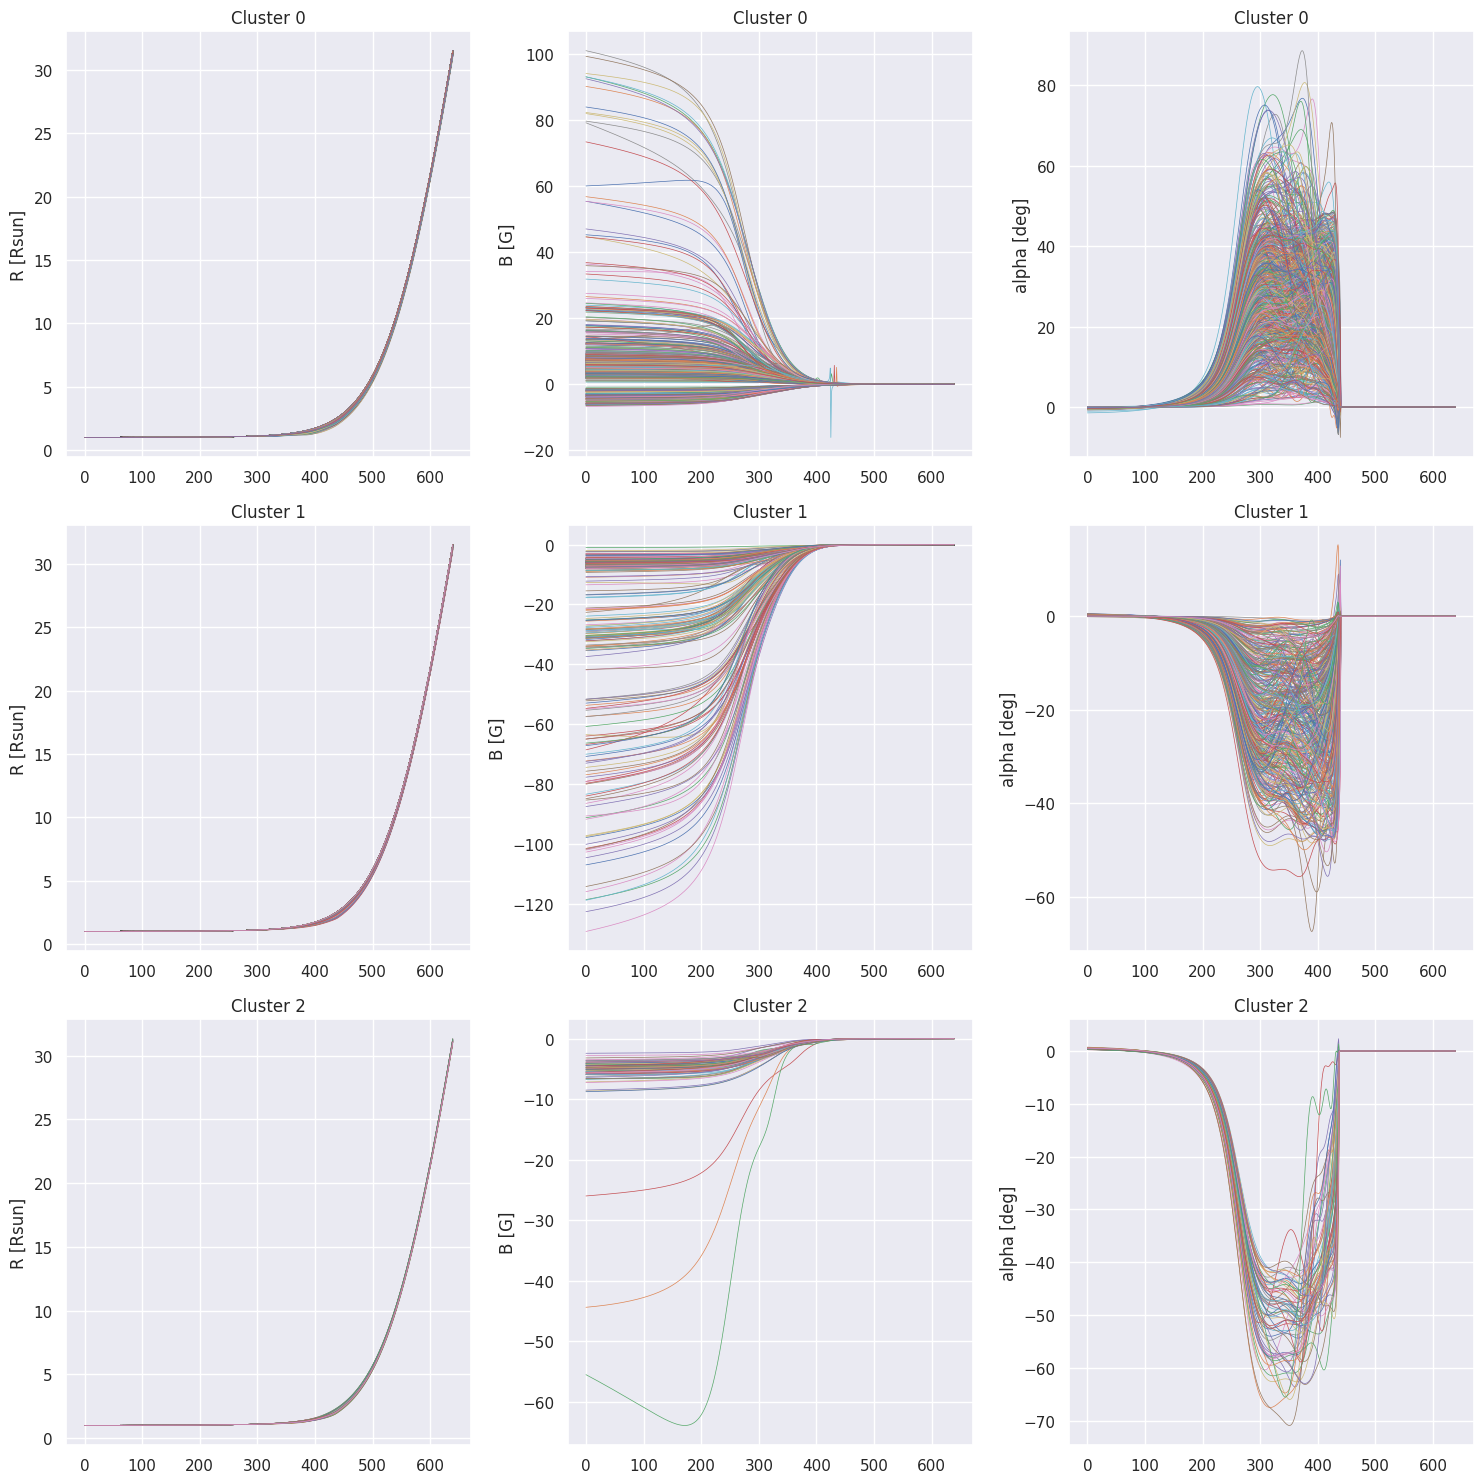

In [22]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

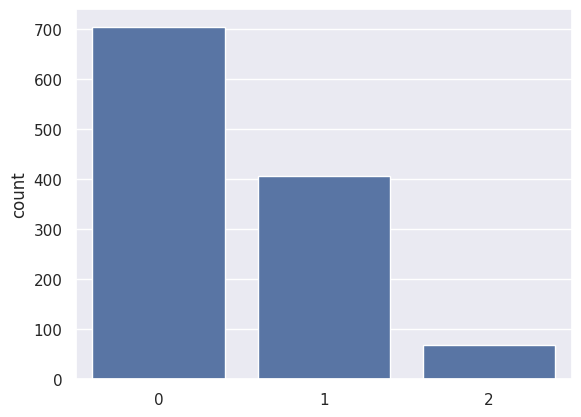

In [23]:
sns.countplot(x=agg.labels_, color='b')

### Grid Search

In [24]:
%%capture
sub_dir = OUT_DIR / 'hierarchical'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_all)
    
    sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
    plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png') 
    

## DBSCAN

In [25]:
# dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=2)
# dbscan_labels = dbscan.fit_predict(transformed_all)
# nclusters = len(set(dbscan_labels))

In [26]:
# sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
# plt.legend(loc='upper right')

### Original Data

In [27]:
# plot_unscaled_clusters(dbscan_labels, nclusters, flows_dict, flow_columns)

### Cluster Distribution

In [28]:
# sns.countplot(x=dbscan_labels, color='b')

### Grid Search

In [38]:
%%capture
sub_dir = OUT_DIR / 'dbscan'
if not sub_dir.exists():
    sub_dir.mkdir()


for k in range(3, 640):
    for i in np.arange(0.05, 0.9, 0.05):
        dbscan = DBSCAN(eps=i, min_samples=k, n_jobs=-1)
        dbscan_labels = dbscan.fit_predict(transformed_all)
        
        nclusters = len(set(dbscan_labels))
        if (nclusters > MAX_CLUSTERS or nclusters < 2):
            continue
        
        save_i = int(i*100)
        sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
        plt.legend(loc='upper right')
        plt.savefig(sub_dir / f'scatter_{k}_{save_i}.png', dpi=200)
        
        plot_unscaled_clusters(dbscan_labels, len(set(dbscan_labels)), flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{k}_{save_i}.png')
    

# Magnetic Field + Inclination

In [ ]:
# separate into file series
scaled_mag_inc = [scaled_flows.iloc[i*640:i*640+640, 1:] for i in range(len(scaled_flows) // 640)]
scaled_mag_inc = [flow.values for flow in scaled_mag_inc]
scaled_mag_inc = np.array([flow.ravel() for flow in np.array(scaled_mag_inc)])
scaled_mag_inc.shape

(1179, 1280)

## PCA

In [ ]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_mag_inc)
transf_pca_640 = pca_640.transform(scaled_mag_inc)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

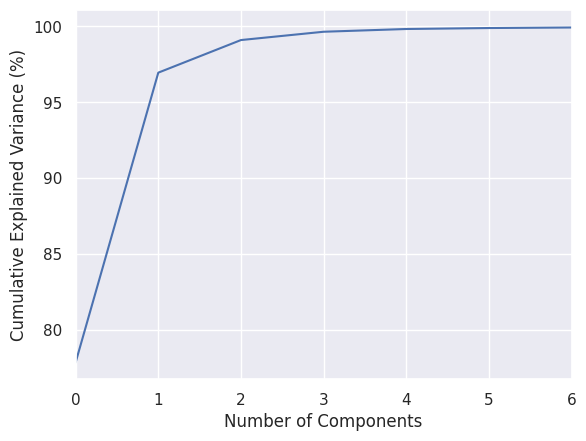

In [ ]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

In [ ]:
pca = PCA(n_components=2)
transformed_mag_inc = pca.fit_transform(scaled_mag_inc)
transformed_mag_inc

array([[-3.783687  , -0.35913395],
       [-2.91464678, -0.80983238],
       [ 2.72833432, -0.90226561],
       ...,
       [-4.85831775,  1.09975747],
       [ 1.7924202 , -0.06651433],
       [-9.05408764, -9.26923896]])

<AxesSubplot: >

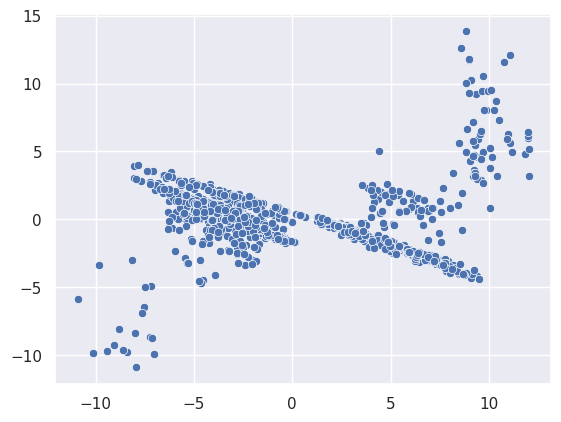

In [ ]:
sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

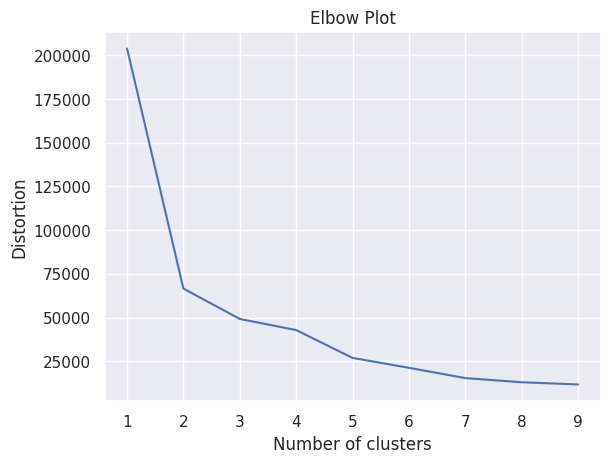

In [ ]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(scaled_flows)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [ ]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')
pca_kmeans_mag_inc_labels = kmeans.fit_predict(transformed_mag_inc)
nclusters = len(set(pca_kmeans_mag_inc_labels))

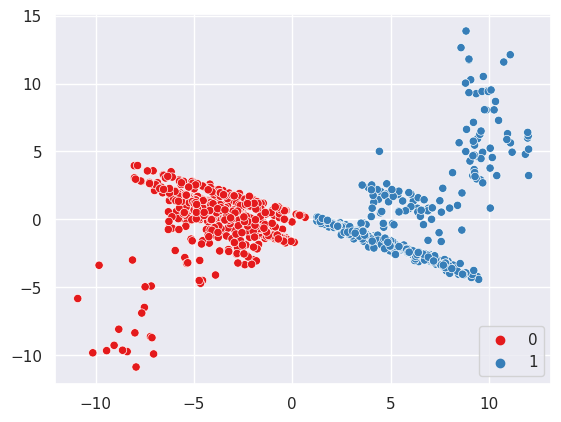

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=pca_kmeans_mag_inc_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

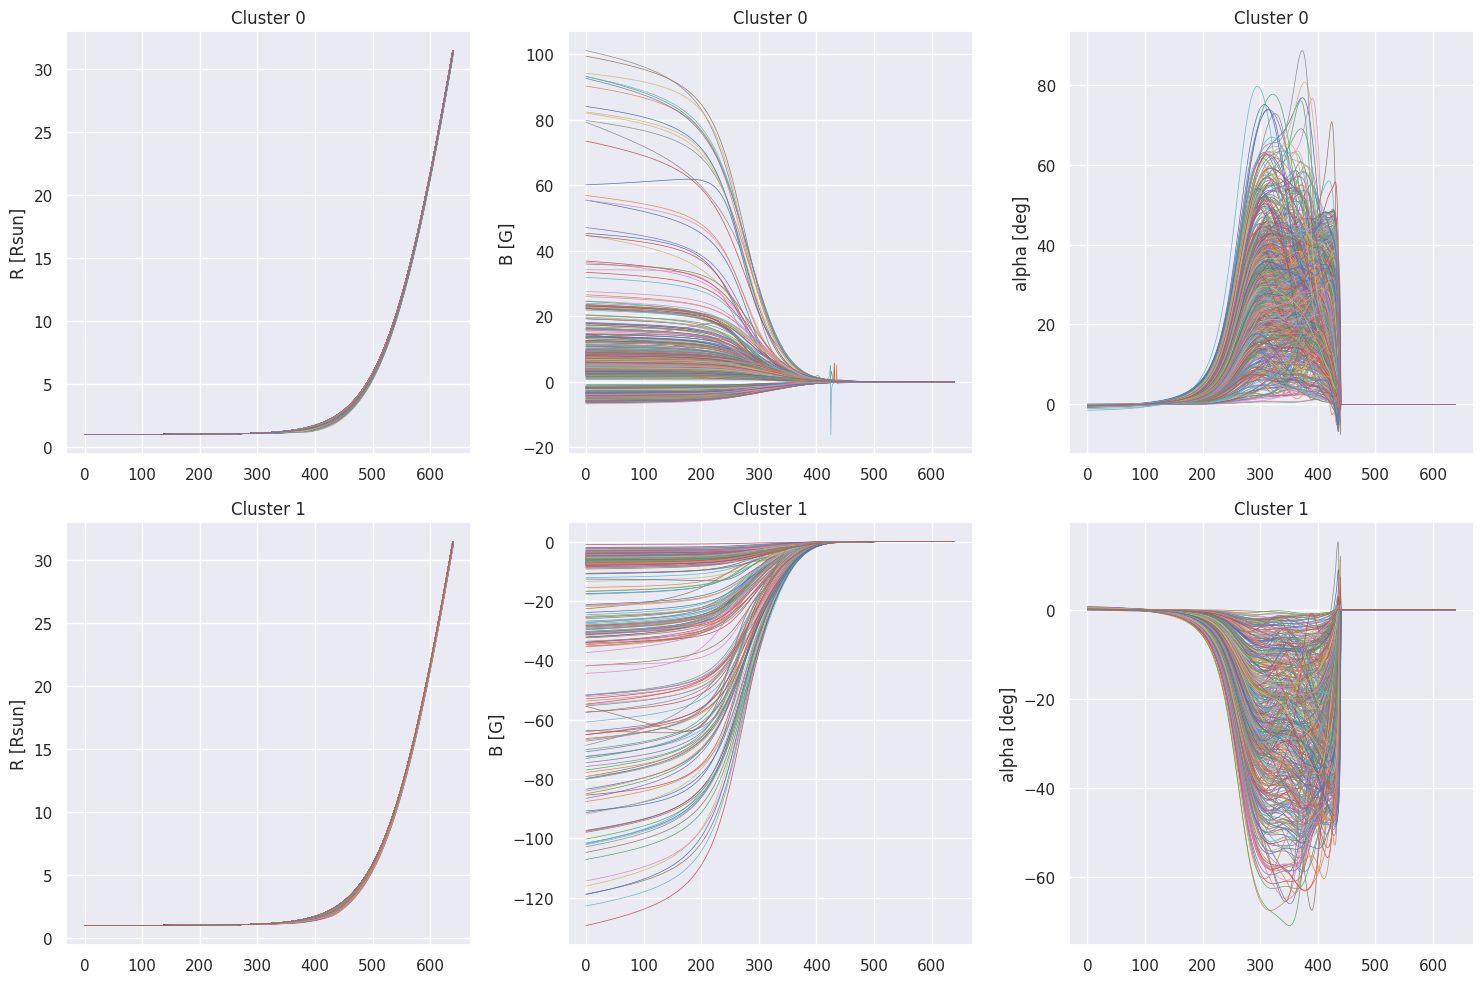

In [ ]:
plot_unscaled_clusters(pca_kmeans_mag_inc_labels, nclusters, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

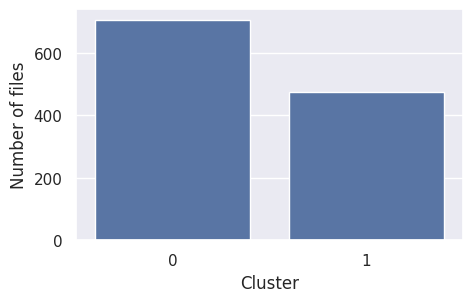

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_mag_inc_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [ ]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag_inc)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

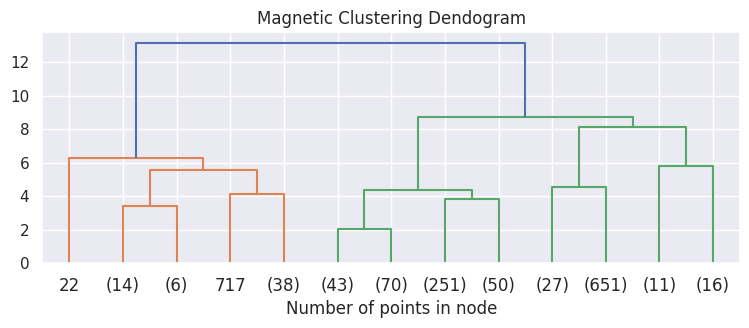

In [ ]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

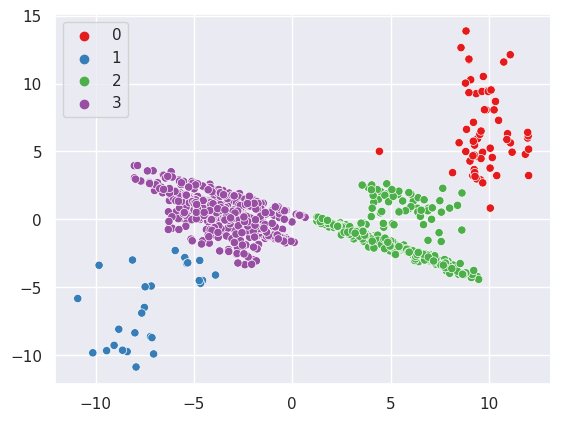

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

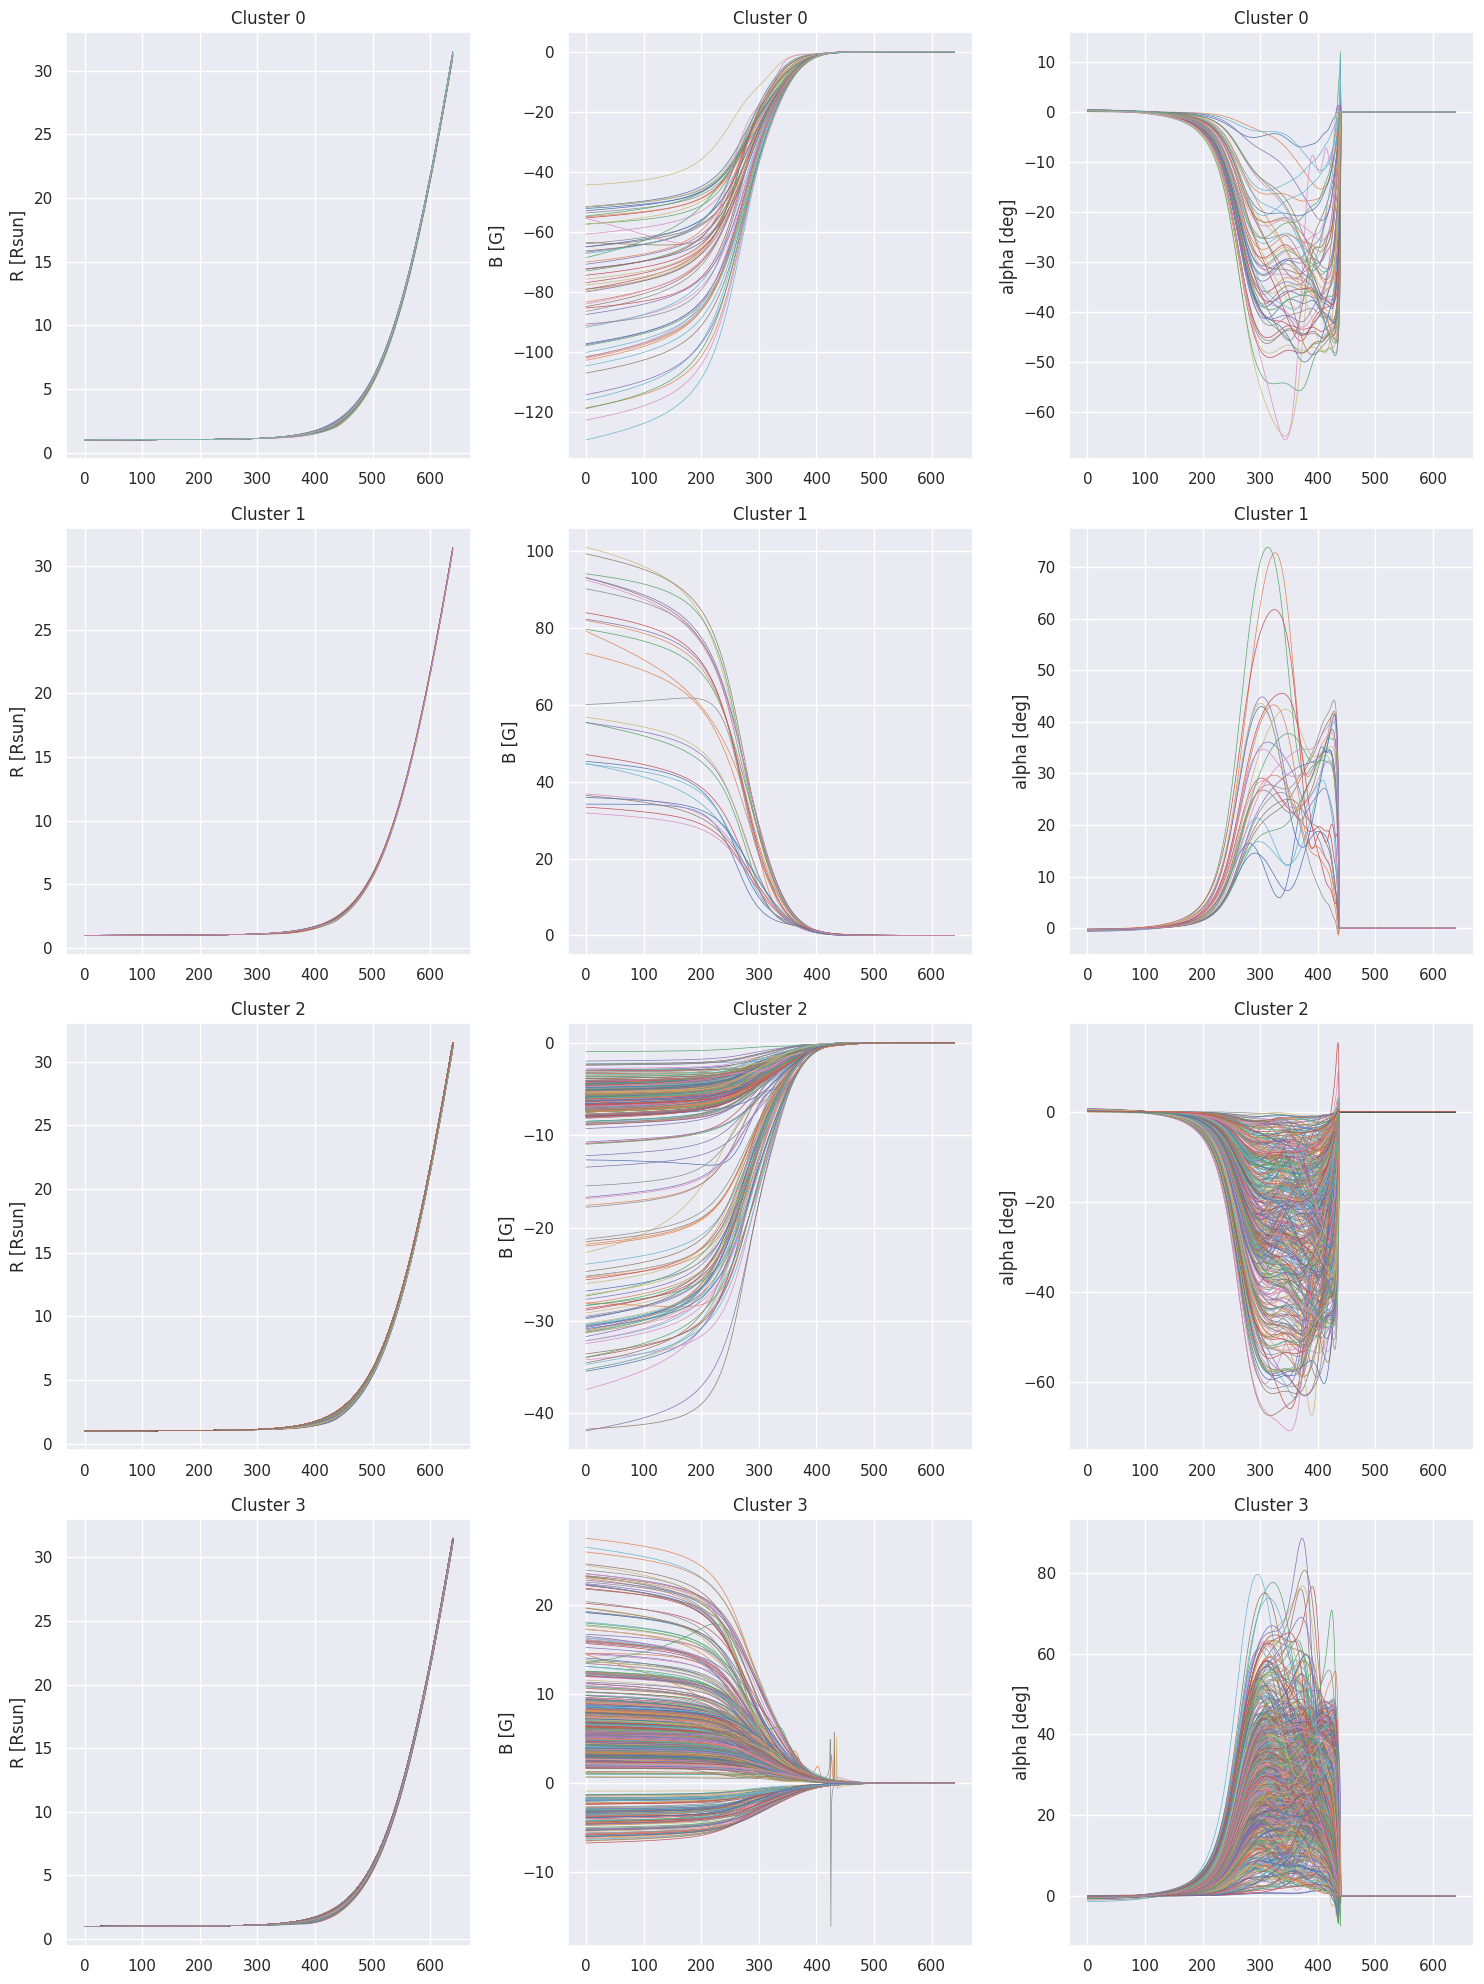

In [ ]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

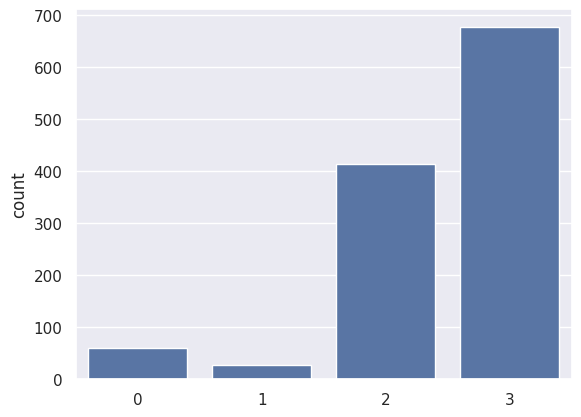

In [ ]:
sns.countplot(x=agg.labels_, color='b')

In [ ]:
%%capture
sub_dir = OUT_DIR / 'alpha'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_alpha)
    
    sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

NameError: name 'transformed_alpha' is not defined

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_mag_inc_labels = dbscan.fit_predict(transformed_mag_inc)
nclusters = len(set(dbscan_mag_inc_labels))


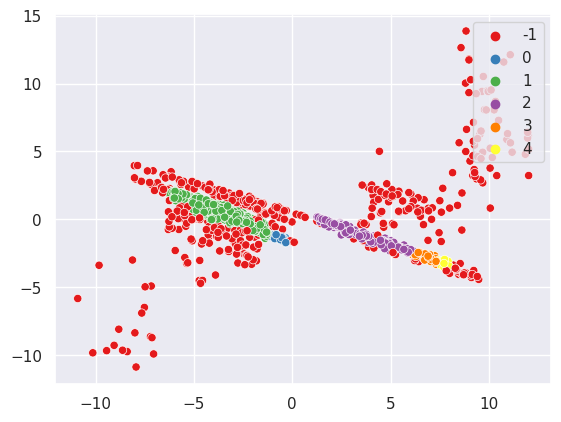

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=dbscan_mag_inc_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

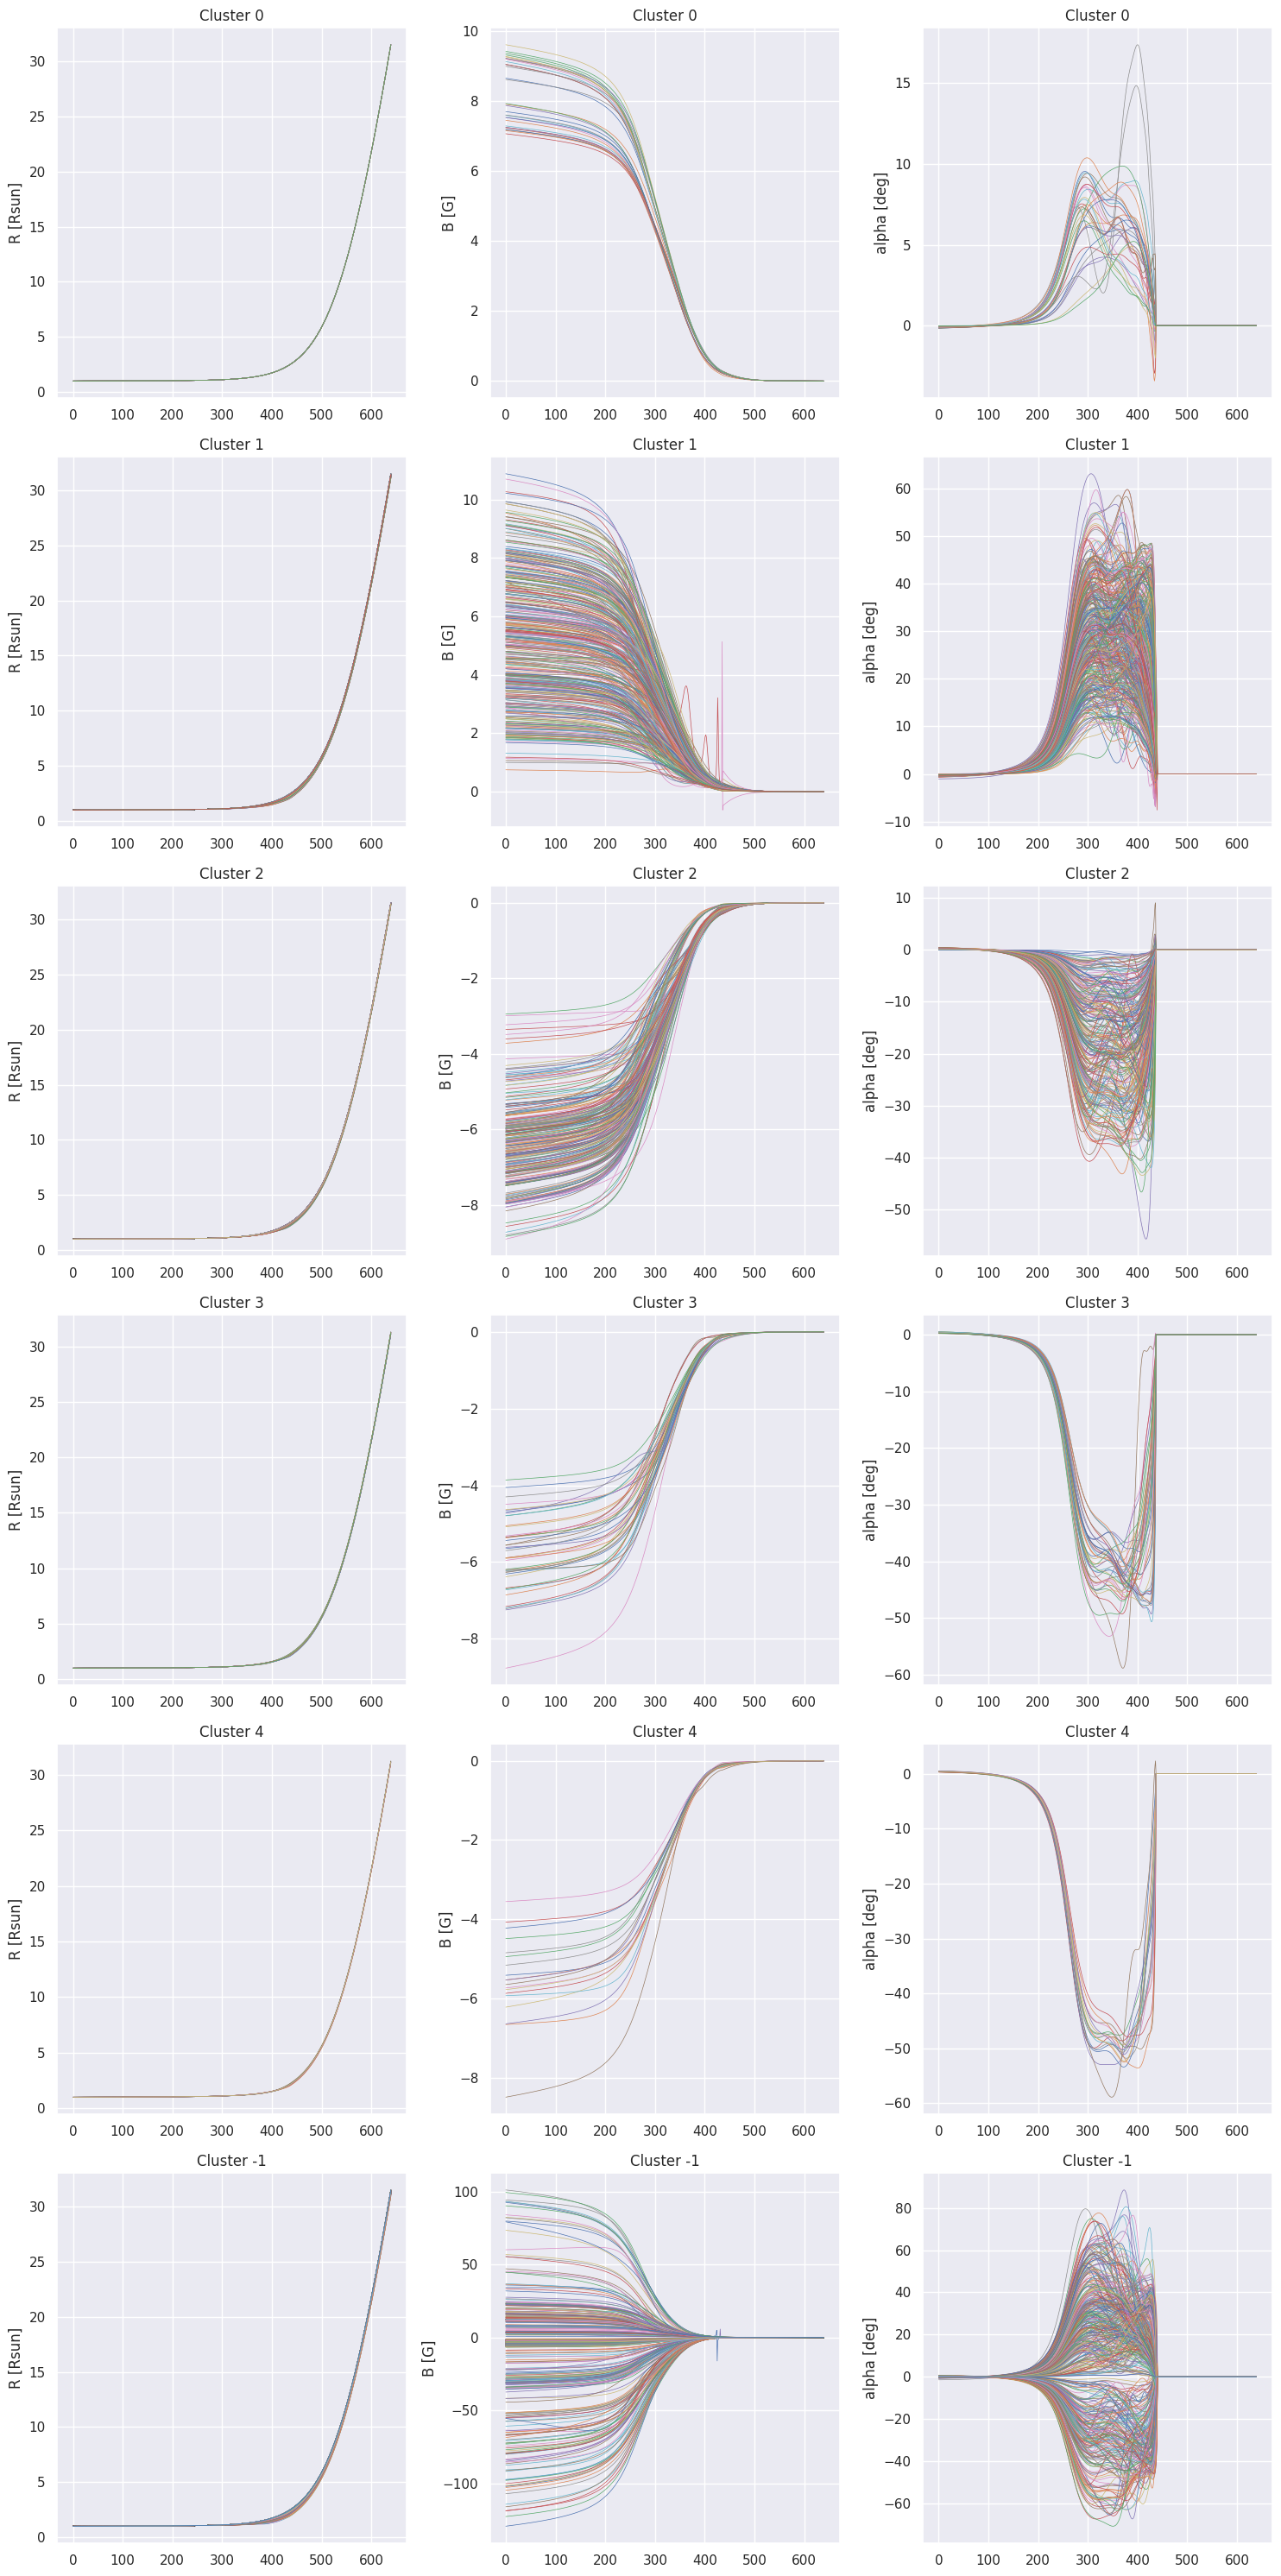

In [ ]:
plot_unscaled_clusters(dbscan_mag_inc_labels, nclusters, flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

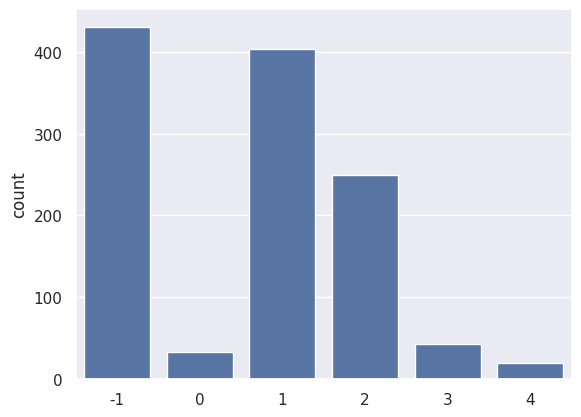

In [ ]:
sns.countplot(x=dbscan_mag_inc_labels, color='b')

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    